# BASELINE UNET
https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical

In [297]:
import torch
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from pycocotools.coco import COCO

from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F


In [298]:

print("Torch", torch.__version__)

DEVICE = 'mps'
def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Torch 1.13.1


In [299]:
DATA_ROOT = Path('../Data/')
IMAGES = DATA_ROOT / Path('images')
MASKS = DATA_ROOT / Path('masks')
LABELS = ['background', 'car', 'wheel', 'lights', 'window']

In [300]:
img_list = list(IMAGES.glob('*'))
mask_list = list(MASKS.glob('*'))

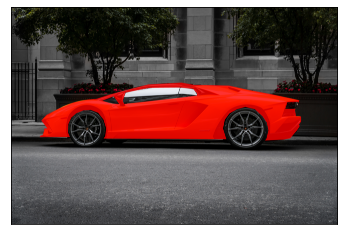

In [310]:
# посмотрим на маску кузова
idx = np.random.randint(0, len(img_list))

img_path = img_list[idx]
mask_path = mask_list[idx]

img = make_grid(read_image(str(img_path)))
# бывает, что у изображения 4 канала
if img.size()[0] == 4:
    img = img[:3, :, :]

mask = read_image(str(mask_path))

# 1 - это маска кузова авто
mask_body = mask == 1

drawn_masks = []
drawn_masks.append(draw_segmentation_masks(img, mask_body, alpha=0.8, colors="red"))

show(drawn_masks)

In [311]:
# make dataset
from torch.utils.data import Dataset, DataLoader

In [397]:
class CarBodyDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        img_paths = list(Path(img_dir).glob('*'))
        mask_paths = list(Path(mask_dir).glob('*'))
        assert len(img_paths) != 0, f'Картинки в {img_dir} отсутствуют'
        assert len(img_paths) == len(mask_paths), \
                f'Кол-во картинок и масок к ним не совпадает {(len(img_paths), len(mask_paths))}'
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.len_dataset = len(img_paths)
        
    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, idx):
        img = read_image(str(self.img_paths[idx]))
        # бывает, что у изображения 4 канала
        if img.size()[0] == 4:
            img = img[:3, :, :]

        
        mask = read_image(str(self.mask_paths[idx]))
        # 1 - это маска кузова авто
        mask_body = mask == 1
        sample = (img, mask_body)
        return sample
    

    


In [398]:
data = CarBodyDataset(IMAGES, MASKS)

In [399]:
data[0]

(tensor([[[179, 184, 179,  ...,  96, 102, 110],
          [180, 184, 179,  ...,  87,  92,  91],
          [181, 185, 180,  ..., 124, 136, 126],
          ...,
          [155, 161, 169,  ..., 140, 147, 145],
          [157, 158, 157,  ..., 145, 149, 147],
          [160, 161, 153,  ..., 144, 145, 143]],
 
         [[117, 122, 118,  ...,  70,  74,  81],
          [118, 122, 118,  ...,  59,  64,  62],
          [119, 123, 119,  ...,  97, 107,  94],
          ...,
          [150, 156, 164,  ..., 136, 143, 141],
          [152, 153, 152,  ..., 141, 145, 143],
          [155, 156, 148,  ..., 140, 141, 139]],
 
         [[ 96, 101,  97,  ...,  55,  60,  67],
          [ 97, 101,  97,  ...,  45,  50,  48],
          [ 98, 102,  98,  ...,  80,  91,  79],
          ...,
          [144, 150, 158,  ..., 127, 134, 132],
          [146, 147, 146,  ..., 130, 134, 132],
          [149, 150, 142,  ..., 129, 130, 128]]], dtype=torch.uint8),
 tensor([[[False, False, False,  ..., False, False, False],
   

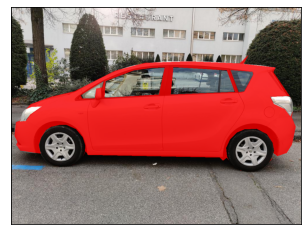

In [421]:
idx = np.random.randint(0, len(data))
sample = data[idx]
img = draw_segmentation_masks(sample[0], sample[1], alpha=0.8, colors="red")
show(img)